In [1]:
import warnings
warnings.filterwarnings("ignore")

import re
import json
import csv
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from cycler import cycler

In [2]:
#rcParams default settings
"https://matplotlib.org/stable/tutorials/introductory/customizing.html"

#rcParams settings
plt.style.use('ggplot')

rcParams['font.family'] = 'sans-serif'
rcParams['font.style'] = 'normal'

rcParams['figure.facecolor'] = 'white'

rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.dpi'] = 300
rcParams['savefig.transparent'] = True

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['axes.labelsize'] = 20
rcParams['axes.labelcolor'] = 'black'
rcParams['axes.edgecolor'] = 'grey'
rcParams['axes.linewidth'] = 3
rcParams['axes.facecolor'] = 'white'
rcParams['axes.titlepad'] = 4
rcParams['axes.titlesize'] = 20

rcParams['xtick.color'] = 'grey'
rcParams['ytick.color'] = 'grey'
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 0
rcParams['xtick.major.size'] = 5
rcParams['ytick.major.size'] = 0

rcParams['lines.linewidth'] = 3
rcParams['lines.markersize'] = 10

rcParams['legend.title_fontsize'] = 15
rcParams['legend.fontsize'] = 10

rcParams['grid.color'] = 'grey'
rcParams['grid.linewidth'] = 0.1

icefire_palette = sns.color_palette("icefire")
sns.set_palette(icefire_palette)

# Functions

In [3]:
# Function to clean tweets
def preliminary_cleaning(t):              
    # Convert to lowercase
    text = t.lower()
        
    # Remove newlines, tabs, and extra whitespace
    text = text.replace('\n', ' ').replace('\t', ' ').replace('&amp;', '&').replace('&gt;', '')
    text = re.sub(r'\s+', ' ', text).strip()
    
    def remove_urls(text):
        # Define the regex pattern for URLs
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        # Use the sub method to replace URLs with an empty string
        cleaned_text = re.sub(url_pattern, '', text)
        return cleaned_text

    def remove_usernames(text):
        # Use a regular expression to find all @usernames at the beginning of the text
        cleaned_text = re.sub(r'^(@\w+\s*)+', '', text)
        return cleaned_text
    
    text = remove_urls(text)
    
    text = remove_usernames(text)
    
    return text

# Function to capitalize and replace specific usernames
def format_username(username):
    # Dictionary for specific replacements
    specific_replacements = {
        'lego_group': 'Lego Group',
        'hm': 'H&M',
        'detushepostdhl': 'DHL',
        'iberdrola_en': 'Iberdrola'
    }
    # Apply specific replacements if available
    if username in specific_replacements:
        return specific_replacements[username]
    # General case for handling 'group'
    if 'group' in username.lower():
        parts = username.split('group')
        return ' '.join([part.capitalize() for part in parts if part]) + ' Group'
    # Capitalize other usernames
    return username.capitalize()

# Reading Data

In [4]:
df = pd.read_json("/home/pansanella/mydata/github/almondo-tweets-retrieval/data/out/filtered_tweets_4.json")

In [5]:
df.head()

,attachments,author_id,created_at,edit_history_tweet_ids,entities,id,lang,public_metrics,text,username,geo
0,{'media_keys': ['13_1610292861630840833']},51801586,2023-01-03 15:18:41+00:00,[1610294585242300416],"{'annotations': [{'end': 6, 'normalized_text':...",1610294585242300416,en,"{'bookmark_count': 0, 'impression_count': 3864...",New ABB E-mobility home charging solution help...,abbgroupnews,NaN
1,{'media_keys': ['3_1612750081463095296']},51801586,2023-01-10 09:57:29+00:00,[1612750467859378178],"{'annotations': [{'end': 2, 'normalized_text':...",1612750467859378176,en,"{'bookmark_count': 0, 'impression_count': 4887...",ABB #technology to facilitate #energyefficienc...,abbgroupnews,NaN
2,{'media_keys': ['13_1613112174939103235']},51801586,2023-01-11 10:01:06+00:00,[1613113765595320321],"{'annotations': [{'end': 51, 'normalized_text'...",1613113765595320320,en,"{'bookmark_count': 0, 'impression_count': 2559...",Better decisions for a greener data center! Ho...,abbgroupnews,NaN
3,{'media_keys': ['3_1613462741569736704']},51801586,2023-01-12 09:09:45+00:00,[1613463229665271809],"{'annotations': [{'end': 19, 'normalized_text'...",1613463229665271808,en,"{'bookmark_count': 0, 'impression_count': 2087...",ABB Formula E Season 9 goes green in Mexico!\n...,abbgroupnews,NaN
4,{'media_keys': ['13_1613831618141261825']},51801586,2023-01-13 09:41:43+00:00,[1613833662625353729],"{'annotations': [{'end': 7, 'normalized_text':...",1613833662625353728,en,"{'bookmark_count': 0, 'impression_count': 1975...",The #ABB Decoded #podcast with Frank Muehlon i...,abbgroupnews,NaN


# Cleaning Data

###### Plot Palette Setting

In [6]:
icefire_palette = sns.color_palette("icefire", n_colors=len(df.username.unique()))
tab20_palette = sns.color_palette("tab20", n_colors=20)
tab10_palette = sns.color_palette("tab10", n_colors=10)

# Metrics Analysis

In [7]:
df['public_metrics']# Use pandas.json_normalize to expand the dictionaries into separate columns
public_metrics_expanded = pd.json_normalize(df['public_metrics'])
df = df.join(public_metrics_expanded)
df = df[['created_at', 'id', 'username', 'like_count', 'quote_count', 'impression_count', 'retweet_count', 'reply_count', 'bookmark_count']]
df.head()

,created_at,id,username,like_count,quote_count,impression_count,retweet_count,reply_count,bookmark_count
0,2023-01-03 15:18:41+00:00,1610294585242300416,abbgroupnews,19,2,3864,7,0,0
1,2023-01-10 09:57:29+00:00,1612750467859378176,abbgroupnews,11,2,4887,4,0,0
2,2023-01-11 10:01:06+00:00,1613113765595320320,abbgroupnews,17,0,2559,5,0,0
3,2023-01-12 09:09:45+00:00,1613463229665271808,abbgroupnews,8,0,2087,4,0,0
4,2023-01-13 09:41:43+00:00,1613833662625353728,abbgroupnews,7,0,1975,1,0,0


In [8]:
df_melted = df.melt(value_vars=['like_count', 'quote_count', 'retweet_count', 'reply_count', 'bookmark_count'], 
                    var_name='Metric', value_name='Value')

In [9]:
df_melted

,Metric,Value
0,like_count,19
1,like_count,11
2,like_count,17
3,like_count,8
4,like_count,7
...,...,...
60245,bookmark_count,0
60246,bookmark_count,0
60247,bookmark_count,0
60248,bookmark_count,0


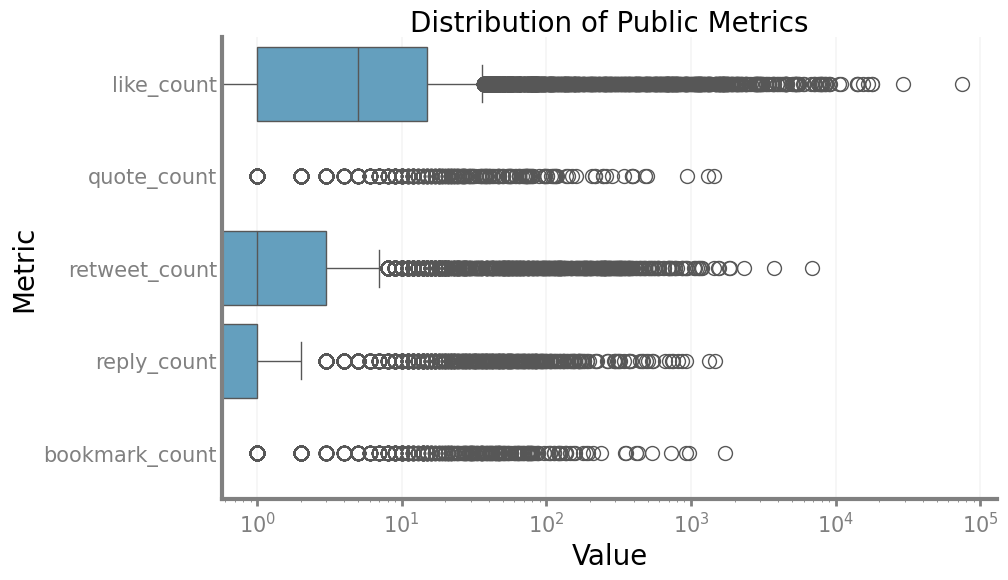

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Value', y='Metric', data=df_melted, orient='h')

plt.title('Distribution of Public Metrics')
plt.xlabel('Value')
plt.xscale('log')
plt.ylabel('Metric')
plt.show()

<Axes: xlabel='impression_count', ylabel='Density'>

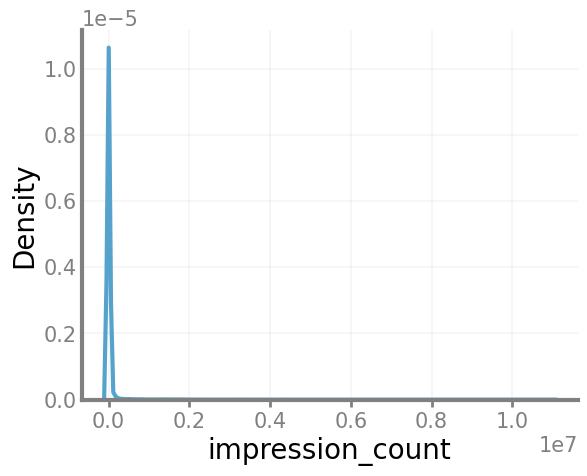

In [11]:
sns.kdeplot(data=df, x='impression_count')